    # Oscillator with morphing waves between saw, rect, tri, sine

In [1]:

%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp

figsize(20,6)

import tensorflow as tf
tf.enable_eager_execution()
import copy




Populating the interactive namespace from numpy and matplotlib


In [14]:
tfdevice='/gpu:0'

In [15]:
prefix="osc_demo_"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm

In [16]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [17]:
def compareMelSpec(seq1, seq2):
    fftSize=2048
    hop=1024  
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    return nrmse(melspec.flatten(), melspec2.flatten())
        

(123,) 8000


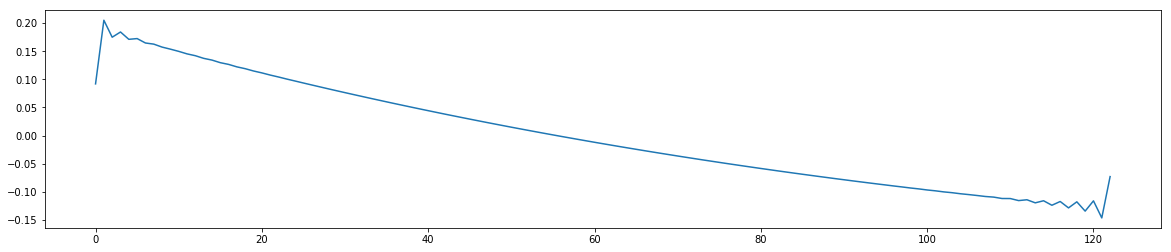

In [18]:
y, sr = librosa.load("audios/397190__cabled-mess__doepfer-a-110-1-vco-saw-c2--8k.wav", sr=8000)
y = y[0:123]
plot(y)
windowSize = len(y)
# nWindows = 1
print(y.shape,  sr)

In [19]:

Audio(data=y[:],rate=sr)

(123,) 8000


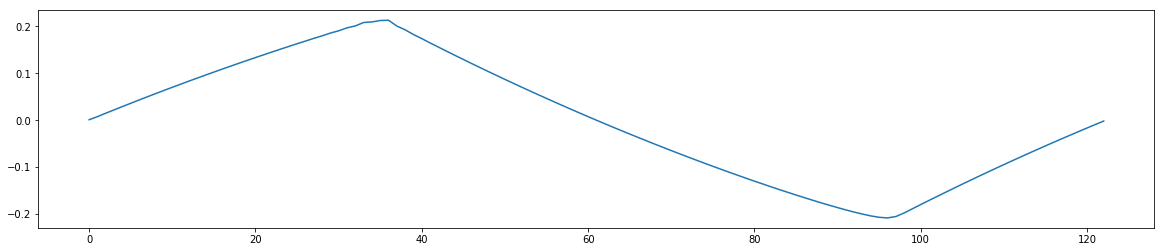

In [20]:
y2, sr2 = librosa.load("audios/398292__cabled-mess__doepfer-a-110-1-vco-triangle-c2--8k.wav", sr=8000)
y2off=0
y2 = y2[y2off:y2off+123] 
plot(y2)
# windowSize2 = 123
# nWindows2 = int(y2.size/windowSize2)
print(y2.shape, sr2)

(123,) 8000


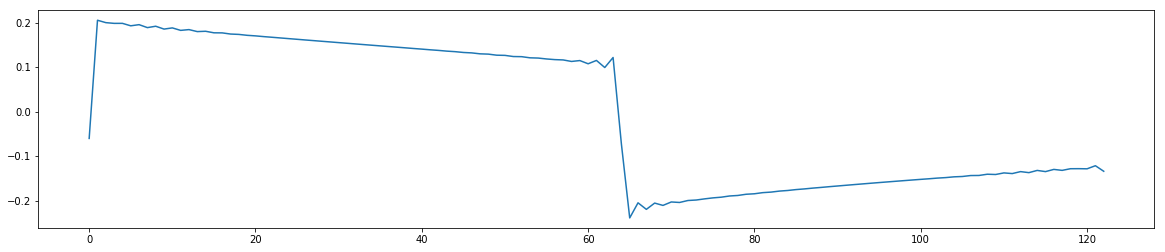

In [21]:
y3, sr3 = librosa.load("audios/397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2--8k.wav", sr=8000)
y3off=122
y3 = y3[y3off:y3off+123]
plot(y3)
# windowSize2 = 123
# nWindows2 = int(y2.size/windowSize2)
print(y3.shape, sr3)

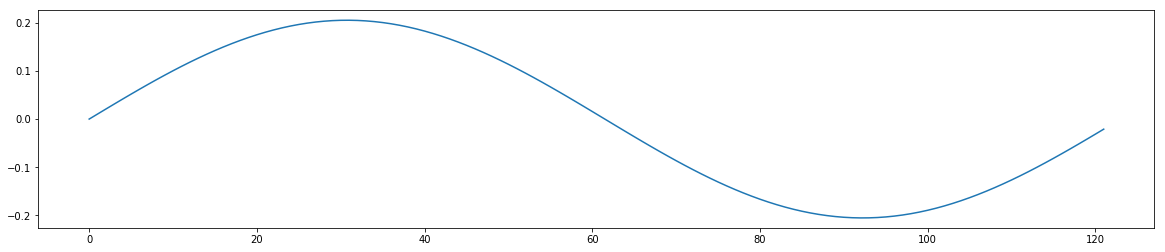

In [22]:
y4 = sin(arange(122)/(123/pi/2)) * np.max(y3)
plot(y4)

In [23]:
#divide out windows
patterns = np.zeros(4, dtype=np.object)
patterns[0] = np.array(y,dtype=float64)
patterns[1] = np.array(y2,dtype=float64)
patterns[2] = np.array(y3,dtype=float64)
patterns[3] = np.array(y4,dtype=float64)


In [24]:
windowSize

123

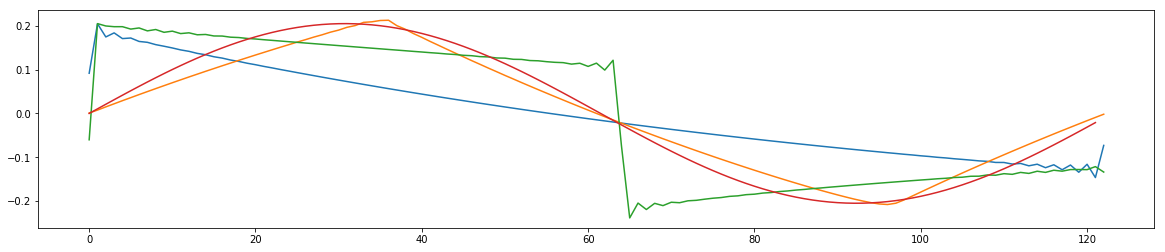

In [25]:
figsize(20,4)
for i in range(int(patterns.shape[0])):
    plot(patterns[i])

plt.savefig(filepre("waves.pdf"))    

In [28]:
#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    with tf.device(tfdevice):
        Netconnectivity = 1
        if p['N'] > 20:
            Netconnectivity = 10.0/p['N'];
        WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
        WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
        WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

        #Scale raw weights     
        Wstar = p['NetSR'] * WstarRaw;
        Win = p['NetinpScaling'] * WinRaw;
        Wbias = p['BiasScaling'] * WbiasRaw;  
        I = np.eye(p['N'])
        xCollector = np.zeros((p['N'], p['learnLength']))
        pCollector = np.zeros((1, p['learnLength']))
        x = np.zeros((p['N'],1))

        allTrainxArgs = np.zeros((p['N'] + 1, 0));
        allTrainOldxArgs = np.zeros((p['N'], 0));
        allTrainWtargets = np.zeros((p['N'], 0));
        allTrainOuts = np.zeros((1, 0));
        patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
        print('Loading patterns: ', end='')
        for i_pattern in range(p['patts'].shape[0]):
            print(i_pattern, " ", end='')
            patt = p['patts'][i_pattern]
            xCollector = np.zeros((p['N'] + 1, p['learnLength']));
            xOldCollector = np.zeros((p['N'], p['learnLength']));
            WTargetCollector = np.zeros((p['N'], p['learnLength']));
            pCollector = np.zeros((1, p['learnLength']));
            x = np.zeros((p['N'], 1));

            for n in range(p['washoutLength'] + p['learnLength']):
                u = patt.take(n, mode='wrap')
                xOld = x
    #             Wtarget = (Wstar.dot(x)) + (Win.dot(u))
                wstarx=tf.matmul(Wstar,x)
                winu = tf.multiply(Win,u)
                Wtarget = tf.add(wstarx, winu)
    #             x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
                xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
                biasedTarget = tf.add(Wtarget, Wbias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
                x = tf.add(xOldLR, biasedTargetLR)
                if n >= p['washoutLength']:
                    xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                    xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                    WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                    pCollector[0, n - p['washoutLength']] = u
                uOld = u

            R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
            patternRs[0,i_pattern] = R
            allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
            allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
            allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
            allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


        Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                          (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

        outsRecovered = Wout.dot(allTrainxArgs);
        NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
        absSize_readout = mean(mean(abs(Wout), axis=0))
        print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
        print("absSize readout: ", absSize_readout)

        W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                          (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
        NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
        absSize_W = mean(mean(abs(W), axis=0))
        print("NRMSE W: ", NRMSE_W, " :: ", end='')
        print("absSize W: ", absSize_W)

    return locals()

params = {'N':1200, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':windowSize*4, 'learnLength':windowSize * 8, 'TychonovAlphaReadout':0.0001,
          'LR': 0.4,
          'patts':patterns[np.array([1,2,3])]
         }

def trainNetwork(): 
    sampleSize = 10
    loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net, net in enumerate(loadedNets):
        print(i_net)
        loadedNets[i_net] = makeLoadedNetwork_v2(params)
    nrmses = [x['NRMSE_W'] for x in loadedNets]
    bestNetwork = np.argmin(nrmses)
    print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], "avg: ", np.mean(nrmses) )
    return copy.deepcopy(loadedNets[bestNetwork])

net = trainNetwork()



0
Loading patterns: 0  1  2  
NRMSE readout:  0.0013638682507455006  :: absSize readout:  0.02932445466566521
NRMSE W:  0.004262734391801859  :: absSize W:  0.24465121987084026
1
Loading patterns: 0  1  2  
NRMSE readout:  0.0010902525058288156  :: absSize readout:  0.026595311794939975
NRMSE W:  0.0027920798840122933  :: absSize W:  0.1818238584054035
2
Loading patterns: 0  1  2  
NRMSE readout:  0.0011133229059879894  :: absSize readout:  0.02579657605888493
NRMSE W:  0.0033724725664607855  :: absSize W:  0.21623024287491313
3
Loading patterns: 0  1  2  
NRMSE readout:  0.0008297626792631382  :: absSize readout:  0.024079791654564288
NRMSE W:  0.0027517634642133413  :: absSize W:  0.18777803653611694
4
Loading patterns: 0  1  2  
NRMSE readout:  0.0011029152024419587  :: absSize readout:  0.026432276860463195
NRMSE W:  0.0031894069073804057  :: absSize W:  0.21618642681923755
5
Loading patterns: 0  1  2  
NRMSE readout:  0.0009361031368276978  :: absSize readout:  0.02395030727645336

In [29]:
%%time
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    with tf.device(tfdevice):    
        Cs = np.zeros((4, 1), dtype=np.object)
        R = net['patternRs'][0,i_pattern]
#         [s,U,V] = tf.svd(R)
        [U,s,V] = svd(R)

#         S = diag(s)
        S = tf.diag(s)
    #     U = U.numpy()

        sinv = tf.matrix_inverse(tf.add(S, tf.multiply(double(pow(alpha, -2)), tf.eye(p['N'], dtype=float64))))
        Snew = tf.matmul(S,sinv)
    #     Snew = tf.matmul(Snew, tf.eye(p['N'], dtype=float64))
        Snew = Snew.numpy()
    #     Snew = (S * linalg.inv(S + pow(alpha, -2) * np.eye(p['N'])))

        C = tf.matmul(U,Snew)
        C = tf.matmul(C,U, adjoint_b=True).numpy()
#     C =  U.dot(Snew).dot(U.conj().T);

    Cs[0,0] = C
    Cs[1,0] = U
    Cs[2,0] = diag(Snew)
    Cs[3,0] = diag(S)

    return locals()

def testConceptor(p, cNet, recallTestLength):
    with tf.device(tfdevice):    
        trials = 1
        attens = np.zeros(trials)
        C = cNet['Cs'][0,0]
        for i_trial in range(trials):
            x_CTestPL = np.zeros((p['N'], recallTestLength))
            z_CTestPL = np.zeros((p['N'], recallTestLength))
    #         p_CTestPL = np.zeros((1, recallTestLength))
            x = 0.5 * np.random.randn(p['N'],1)
            z = x
    #         matW = tf.constant(cNet['net']['W'])
            for n in range(recallTestLength + p['washoutLength']):
                xOld = x
                Wtarget = (cNet['net']['W'].dot(x))
    #             Wtarget = tf.matmul(matW, x).numpy()

                z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))

    #             xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
    #             biasedTarget = tf.add(Wtarget, cNet['net']['Wbias'])
    #             biasedTarget = tf.tanh(biasedTarget)
    #             biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
    #             z = tf.add(xOldLR, biasedTargetLR)

                x = C.dot(z)
    #             x = tf.matmul(C,z).numpy()
                xPrev = x
                if (n > p['washoutLength']):
                    x_CTestPL[:,n-p['washoutLength']] = x.T
    #                 z_CTestPL[:,n-p['washoutLength']] = z.numpy().T
                    z_CTestPL[:,n-p['washoutLength']] = z.T
    #                 p_CTestPL[:,n-p['washoutLength']] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))

    #         attenuation = np.mean(pow(np.sum(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.sum(z_CTestPL[:,:], axis=1),2))
            attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
            attens[i_trial] = attenuation
        
    return np.mean(attens)



CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs


In [30]:
%%time
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cnet = computeConceptor(params, net, args[0], aperture)
    atten = testConceptor(params, cnet, windowSize*10)
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

#store conceptors with calculated apertures
patternCs = np.zeros(len(apertures), dtype=np.object)
for i_patt in range(patternCs.size):
    print(i_patt, " ", end='')
    patternCs[i_patt] = computeConceptor(params, net, i_patt, apertures[i_patt])
print("Done")

Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  2.15313e-08        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034  9.06949e-09        golden
Pattern:  0
Computing conceptor, alpha:  763.9320225002102
    3        763.932  6.29322e-09        golden
Pattern:  0
Computing conceptor, alpha:  798.6302376053853
    4         798.63  5.84729e-09        parabolic
Pattern:  0
Computing conceptor, alpha:  875.5466425336377
    5        875.547  5.03841e-09        golden
Pattern:  0
Computing conceptor, alpha:  923.0835950717476
    6        923.084  4.64135e-09        golden
Pattern:  0
Computing conceptor, alpha:  952.4630474618901
    7        952.463  4.42977e-09        golden
Pattern:  0
Computing conceptor, alpha:  970.6205476098576
    8        970.621  4.30003e-09        golden
Pattern:  0
Computing conceptor, alpha:  981.8424998520327
    9        981.842  4.2476

In [32]:
def compareMelSpec(seq1, seq2):
    fftSize=2048
    hop=1024  
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    return nrmse(melspec.flatten(), melspec2.flatten())
        

0.0031571707842707134
0.011865363795291172
0.003636608601366402


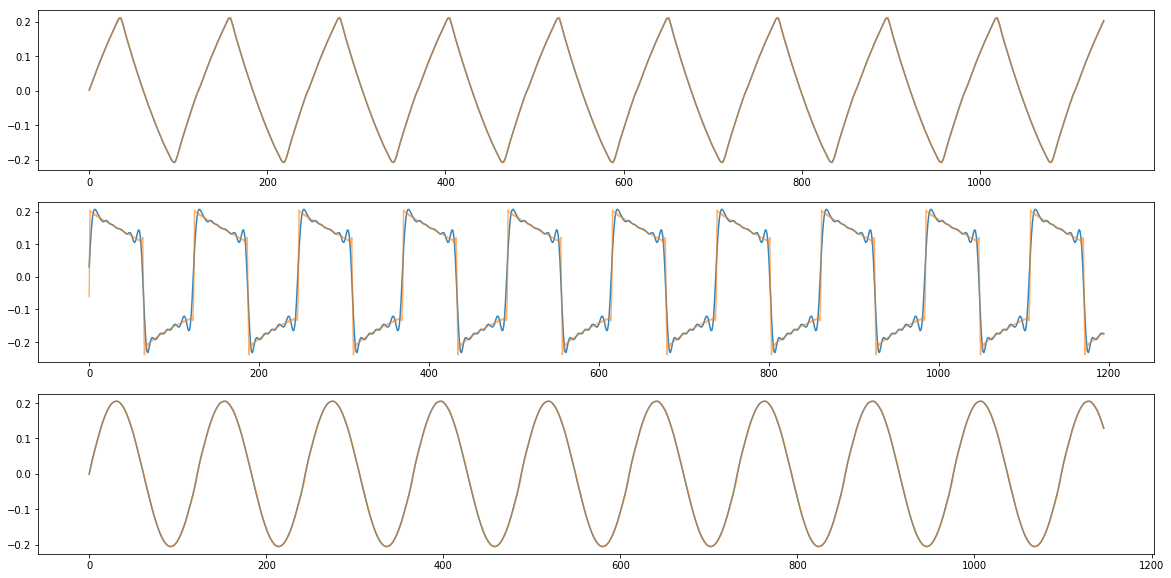

In [33]:
def plotConceptorPattern(p, cNet, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    z_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].shape[0]))
    C = cNet['Cs'][0,0]
    x = 0.5 * np.random.randn(p['N'],1)
    z = x
    for n in range(recallTestLength + p['washoutLength']):
        xOld = x
        Wtarget = (cNet['net']['W'].dot(x))
        z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > p['washoutLength']):
            x_CTestPL[:,n-p['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-p['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:p['patts'][i_pattern].size*2],p['patts'][i_pattern])
#     print(templateScan)
    matchPoint = np.argmax(templateScan)
#     print(matchPoint)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = compareMelSpec(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern,alpha=0.9)
    plot(targetPattern, alpha=0.6)
#         ax = subplot(subr, p['patts'].shape[0], suboff + i_pattern + 1)
#         ax.set_title("S:" + str(int(suboff/p['patts'].shape[0])) + ", p: " + str(i_pattern) + ", a: " + str(cNet['alphas'][i_pattern]))
#     plot(p_CTestPL[:,:,i_pattern].T)
#     plot([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
figsize(20,10)
for i_patt in range(len(apertures)):
    subplot(len(apertures), 1, i_patt+1)
#    cnet = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])
    plotConceptorPattern(params, patternCs[i_patt], windowSize * 10, i_patt)

plt.savefig(filepre("tests.pdf"))

In [14]:
# #store conceptors with calculated apertures
# patternCs = np.zeros(len(apertures), dtype=np.object)
# for i_patt in range(patternCs.size):
#     print(i_patt, " ", end='')
#     patternCs[i_patt] = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])
# print("Done")

In [176]:
# import dill as pickle
# ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
# with open(r"models/osc_c1_c2_pitchbend" + ts + ".pickled", "wb") as output_file:    
#     pickle.dump(patternCs, output_file, protocol=0)

In [79]:
a = tf.random_normal([3])
a.length

AttributeError: 'EagerTensor' object has no attribute 'length'

In [115]:
x = tf.contrib.eager.Variable(0.5 * np.random.randn(5,1))
print(x)
x = tf.add(x, tf.random_normal([5,1],0, 0.5, dtype=float64))
print(x)

<tf.Variable 'Variable:0' shape=(5, 1) dtype=float64, numpy=
array([[-1.33219221],
       [-0.0602114 ],
       [-0.42047567],
       [-0.11384676],
       [ 0.17032145]])>
tf.Tensor(
[[-1.75419418]
 [ 0.45668693]
 [-0.80501014]
 [-0.74645053]
 [ 0.32743296]], shape=(5, 1), dtype=float64)


In [140]:
def conceptorAnd(C1, C2):
    return linalg.inv(linalg.inv(C1) + linalg.inv(C2) - np.eye(C1.shape[0]))

def conceptorOr(C1, C2):
    I = np.eye(C1.shape[0])
    x1 = C1.dot(linalg.inv(I - C1))
    x2 = C2.dot(linalg.inv(I - C2))
    return linalg.inv(I + linalg.inv(x1 + x2))

def conceptorNot(C1):
    return 1 - C1

def render(p, net, mixCtl1, mixCtl2, mixCtl3, C1, C2, C3, srCtl, lrCtl, oversample=1, rl=8000):
    audio = np.zeros(rl)
    with tf.device('/gpu:1'):
        x = tf.contrib.eager.Variable(0.5 * np.random.randn(p['N'],1))
        C1 = tf.constant(C1)
        C2 = tf.constant(C2)
        C3 = tf.constant(C3)
        C = C1
        srCtl = tf.constant(srCtl)
        mixCtl1 = tf.constant(mixCtl1)
        mixCtl2 = tf.constant(mixCtl2)
        mixCtl3 = tf.constant(mixCtl3)
        orgLR = p['LR']
        LR = orgLR
        matW = tf.constant(net['W'])
        matBias = tf.constant( net['Wbias'])
        matWout = tf.constant(net['Wout'])  
        tfone = tf.constant(double(1.0), dtype=float64)
        #run to washout
        for n in range(500):
            xOld = x
            Wtarget = tf.matmul(matW, x)

            xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
            biasedTarget = tf.add(Wtarget, matBias)
            biasedTarget = tf.tanh(biasedTarget)
            biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
            z = tf.add(xOldLR, biasedTargetLR)
            x = tf.matmul(C,z)



        prevLR = -1
        for n in range(rl):

            LR = double(orgLR * lrCtl[n])
            newnote = lrCtl[n] != prevLR
            prevLR = lrCtl[n]
            noise = 0
            if n % 500 == 0:
                print(n, " / ", rl)
            C = tf.add_n([tf.multiply(mixCtl1[n], C1), tf.multiply(mixCtl2[n], C2), tf.multiply(mixCtl3[n], C3)])
            newSample=0
            for i_oversample in range(oversample):
                xOld = x
                Wtarget = tf.matmul(tf.multiply(srCtl[n],matW), x)

                xOldLR = tf.multiply(double(1.0-LR), xOld)
                biasedTarget = tf.add(Wtarget, matBias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(LR, biasedTarget)
                z = tf.add(xOldLR, biasedTargetLR)

                x = tf.matmul(C,z)

                xBias = tf.concat([tf.transpose(x)[0],[1]],0)
                xBias = tf.expand_dims(xBias,1)
                netOutput = tf.matmul(matWout, xBias)

                newSample = newSample + netOutput.numpy()

            audio[n] = newSample/oversample
    return audio



CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 22.9 µs


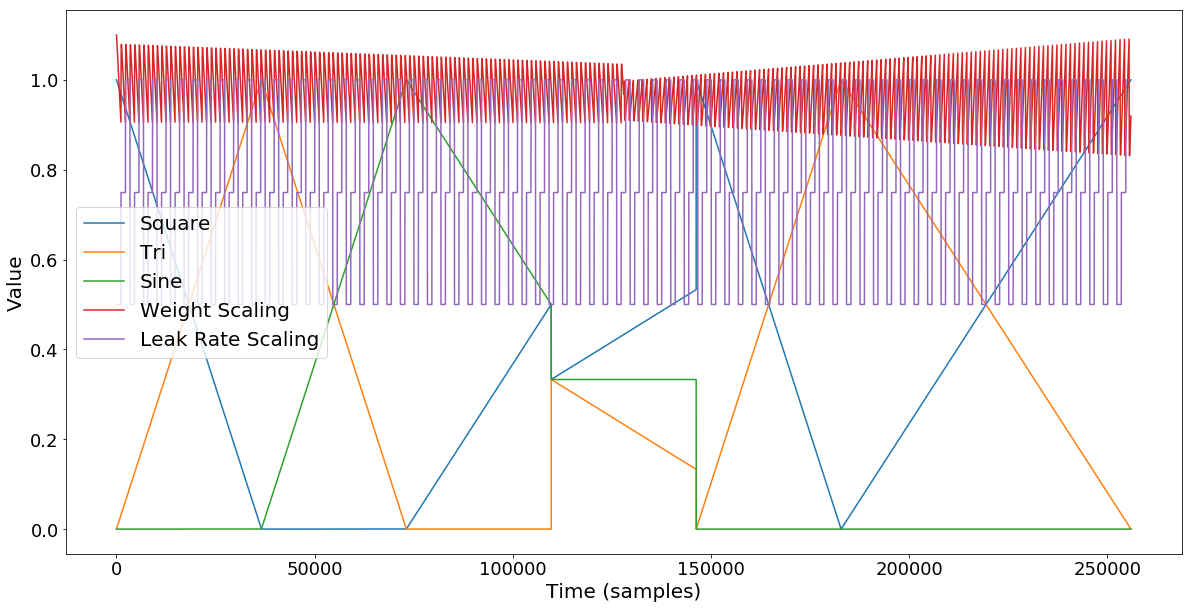

In [11]:
%time
bars =32
rl = 8000*bars
def saw(renderLen, freq, phase):
    ar = np.zeros(renderLen)
    waveLen = 1.0/freq * sr
    inc = 1 / waveLen
    
    for i in range(renderLen):
        ar[i] = phase
        phase = phase + inc
        if phase > 1.0:
            phase = phase - 1.0
    return ar

def pulse(renderLen, freq, phase, pulseWidth):
    ar = np.zeros(renderLen)
    waveLen = 1.0/freq * sr
    inc = 1 / waveLen
    
    for i in range(renderLen):
        ar[i] = phase < pulseWidth
        phase = phase + inc
        if phase > 1.0:
            phase = phase - 1.0
    return ar
    
figsize(20,10)
fig =figure(1)
prl = int(rl/7)
pbar = bars/7
mix1 = np.concatenate((1.0-saw(prl, 1/pbar,0), np.zeros(prl), saw(prl, 1/pbar,0) * 0.5, (saw(prl, 1/pbar,0)* 0.2) +(np.ones(prl) * 0.333), 1.0-saw(prl, 1/pbar,0), saw(prl*2, 1/pbar*0.5,0) ))
mix2 = np.concatenate((saw(prl, 1/pbar,0), 1.0-saw(prl, 1/pbar,0), np.zeros(prl), (np.ones(prl) * 0.333) - (saw(prl, 1/pbar,0)* 0.2), saw(prl, 1/pbar,0), 1.0 - saw(prl*2, 1/pbar*0.5,0)  ))
mix3 = np.concatenate((np.ones(prl) *0.0, saw(prl, 1/pbar,0), ((1.0-saw(prl, 1/pbar,0)) * 0.5)+0.5, np.ones(prl) * 0.333, np.zeros(prl), np.zeros(prl*2)  ))

sequence=np.concatenate((np.tile(np.array([0,7,12]),15), np.tile(np.array([0,7,12]),15), np.tile(np.array([0,7,12]),15), np.tile(np.array([0,7,12]),15), np.tile(np.array([0,7,12]),15)))

stepSize = int(rl/sequence.shape[0])
lrCtl = np.zeros(0)
for note in sequence:
    lrCtl = np.append(lrCtl, np.ones(stepSize) * 0.5 * (pow(2,note/12) if note >= 0 else 0))


srCtl = np.zeros(0)
for v in range(rl):
    phase = v/float(rl)
    sample = (1.1 - (phase*0.1) + ((1.0-phase) * 0.1 if v > rl/2 else 0)) - (((v % stepSize) / stepSize) * (0.2 - (phase * 0.1) + ((1.0-phase) * 0.3 if v > rl/2 else 0))) 
    srCtl = np.append(srCtl, sample)
# srCtl =  np.ones(rl) #saw(rl, 1/8.,0.0) * 0.1 + 0.9
srCtl[int(rl/2):] = srCtl[int(rl/2):][::-1]
#smooth the envelope
for n in range(srCtl.shape[0]-1):
    srCtl[n+1] = (srCtl[n+1] *0.03) + (srCtl[n] * 0.97)
# plt.title("Conceptor Morph")

plot(mix1, label="Square")
plot(mix2, label="Tri")
plot(mix3, label="Sine")
plot(srCtl, label="Weight Scaling")
plot(lrCtl, label="Leak Rate Scaling")
# xlabel("sample",fontsize=20)
matplotlib.rcParams.update({'font.size': 16})
plt.legend(fontsize=20)  
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.savefig(filepre("score.pdf"), bbox_inches='tight')

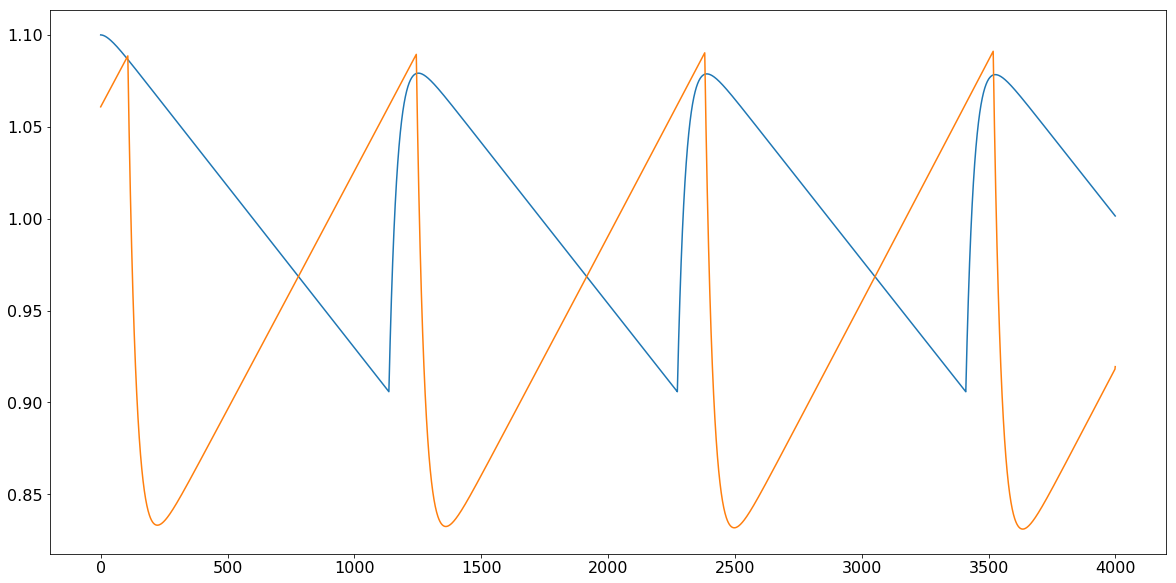

In [8]:
plot(srCtl[:4000])
plot(srCtl[-4000:])

In [171]:
%%time
alen = int(lrCtl.shape[0] *1.0)

audio = render(params, net, mix1[:alen], mix2[:alen], mix3[:alen],
               patternCs[0]['Cs'][0,0], patternCs[1]['Cs'][0,0],  
               patternCs[2]['Cs'][0,0],
               srCtl[:alen], lrCtl[:alen], rl=alen, oversample=1, )
print("done")

0  /  255825
500  /  255825
1000  /  255825
1500  /  255825
2000  /  255825
2500  /  255825
3000  /  255825
3500  /  255825
4000  /  255825
4500  /  255825
5000  /  255825
5500  /  255825
6000  /  255825
6500  /  255825
7000  /  255825
7500  /  255825
8000  /  255825
8500  /  255825
9000  /  255825
9500  /  255825
10000  /  255825
10500  /  255825
11000  /  255825
11500  /  255825
12000  /  255825
12500  /  255825
13000  /  255825
13500  /  255825
14000  /  255825
14500  /  255825
15000  /  255825
15500  /  255825
16000  /  255825
16500  /  255825
17000  /  255825
17500  /  255825
18000  /  255825
18500  /  255825
19000  /  255825
19500  /  255825
20000  /  255825
20500  /  255825
21000  /  255825
21500  /  255825
22000  /  255825
22500  /  255825
23000  /  255825
23500  /  255825
24000  /  255825
24500  /  255825
25000  /  255825
25500  /  255825
26000  /  255825
26500  /  255825
27000  /  255825
27500  /  255825
28000  /  255825
28500  /  255825
29000  /  255825
29500  /  255825
3000

234000  /  255825
234500  /  255825
235000  /  255825
235500  /  255825
236000  /  255825
236500  /  255825
237000  /  255825
237500  /  255825
238000  /  255825
238500  /  255825
239000  /  255825
239500  /  255825
240000  /  255825
240500  /  255825
241000  /  255825
241500  /  255825
242000  /  255825
242500  /  255825
243000  /  255825
243500  /  255825
244000  /  255825
244500  /  255825
245000  /  255825
245500  /  255825
246000  /  255825
246500  /  255825
247000  /  255825
247500  /  255825
248000  /  255825
248500  /  255825
249000  /  255825
249500  /  255825
250000  /  255825
250500  /  255825
251000  /  255825
251500  /  255825
252000  /  255825
252500  /  255825
253000  /  255825
253500  /  255825
254000  /  255825
254500  /  255825
255000  /  255825
255500  /  255825
done
CPU times: user 3min 27s, sys: 8.52 s, total: 3min 35s
Wall time: 3min 15s


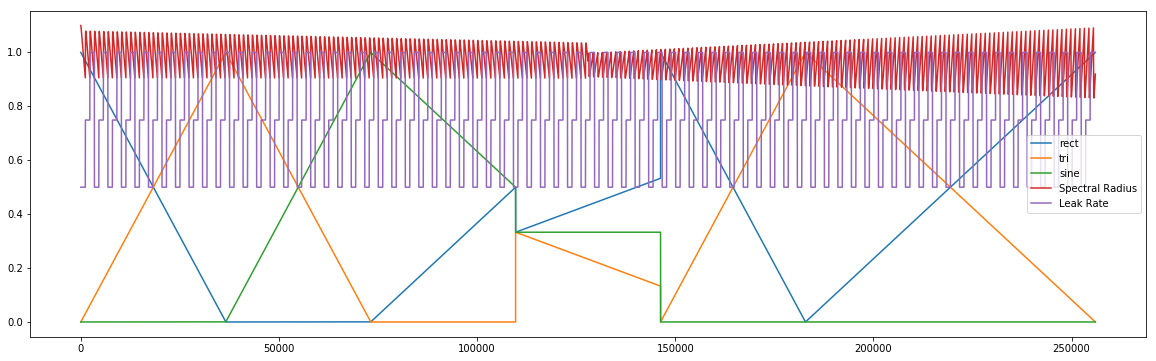

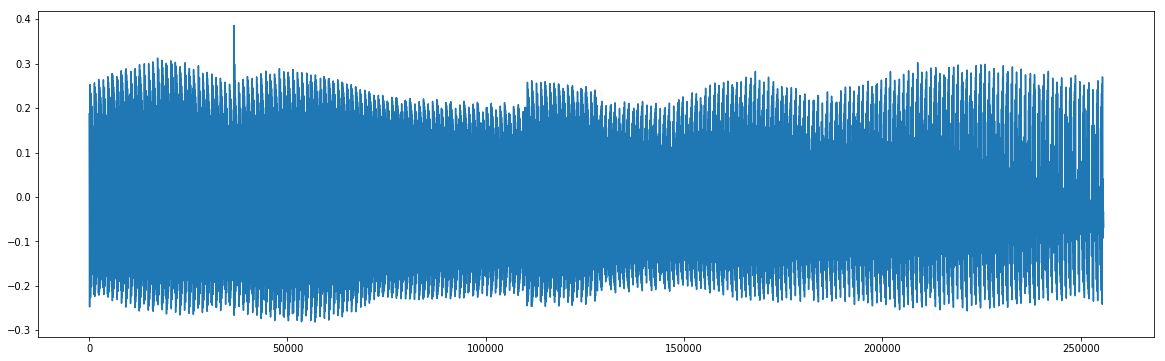

In [183]:
figsize(20,6)
figure(1)
plot(mix1, label="rect")
plot(mix2, label="tri")
plot(mix3, label="sine")
plot(srCtl, label="Spectral Radius")
plot(lrCtl, label="Leak Rate")
plt.legend()   
figure(2)
plot(audio[:])
# plot(y[:audio.size])
librosa.output.write_wav(filepre("demo.wav"), librosa.resample(audio/np.max(audio), sr, 44100), 44100)
Audio(data=audio,rate=sr)


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


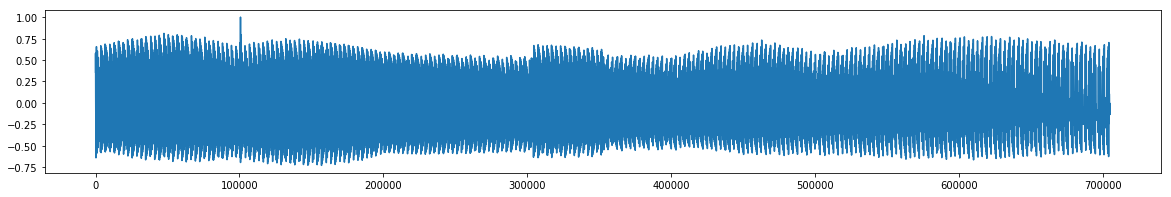

In [5]:
figsize(20,3)
audio, sr = librosa.load(filepre("demo.wav"))
plot(audio)


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


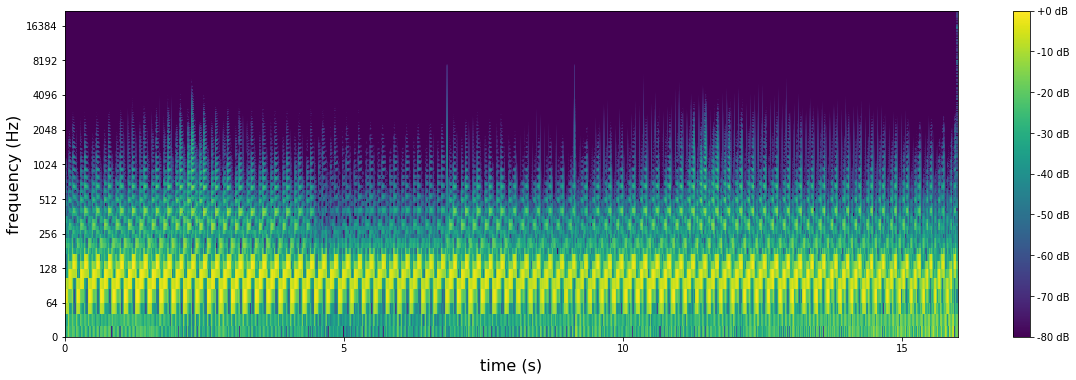

In [10]:
figsize(20,6)
import librosa.display
CQT = librosa.amplitude_to_db(np.abs(librosa.stft(audio, n_fft=2048)), ref=np.max)
ax = librosa.display.specshow(CQT, x_axis='time', y_axis='log', sr=44100, cmap=plt.get_cmap('viridis'))
plt.colorbar(format='%+2.0f dB')
ax.set_ylabel("frequency (Hz)", fontsize=16)
ax.set_xlabel("time (s)", fontsize=16)
# ax.set_title('ESNSPF', fontsize=22)

# CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=2048), ref=np.max)
# librosa.display.specshow(CQT, y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Constant-Q power spectrogram (note)')
plt.savefig(filepre("seq_spectrogram.pdf"), bbox_inches='tight')

In [147]:
Audio(data=audio[150000:],rate=sr)